## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4.):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )

In [9]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=["accuracy"], optimizer=optimizer)


    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00


W0112 11:55:05.971387 4722724288 deprecation.py:323] From /Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

W0112 11:55:06.573797 4722724288 deprecation_wrapper.py:119] From /Users/yiheng/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 70us/step - loss: 6.0338 - accuracy: 0.3309 - val_loss: 6.4140 - val_accuracy: 0.2422
Epoch 2/25
50000/50000 [==============================] - 3s 62us/step - loss: 4.3939 - accuracy: 0.4412 - val_loss: 5.5432 - val_accuracy: 0.3138
Epoch 3/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.9730 - accuracy: 0.4842 - val_loss: 4.8186 - val_accuracy: 0.3951
Epoch 4/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.6978 - accuracy: 0.5091 - val_loss: 4.4280 - val_accuracy: 0.4278
Epoch 5/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.4822 - accuracy: 0.5314 - val_loss: 4.2215 - val_accuracy: 0.4459
Epoch 6/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.2889 - accuracy: 0.5509 - val_loss: 4.0399 - val_accuracy: 0.4697
Epoch 7/25
50000/50000 [==============================] - 3s 62us/st

50000/50000 [==============================] - 3s 66us/step - loss: 3.9566 - accuracy: 0.4868 - val_loss: 4.9210 - val_accuracy: 0.3998
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.6965 - accuracy: 0.5089 - val_loss: 4.3993 - val_accuracy: 0.4491
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.4768 - accuracy: 0.5319 - val_loss: 4.2725 - val_accuracy: 0.4459
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.2998 - accuracy: 0.5525 - val_loss: 4.0917 - val_accuracy: 0.4591
Epoch 7/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.1380 - accuracy: 0.5667 - val_loss: 3.9621 - val_accuracy: 0.4730
Epoch 8/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9960 - accuracy: 0.5818 - val_loss: 3.9968 - val_accuracy: 0.4688
Epoch 9/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.8471 - accuracy: 0.5979 - val_loss: 4.0860 - val

Epoch 4/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.6917 - accuracy: 0.5080 - val_loss: 4.4909 - val_accuracy: 0.4321
Epoch 5/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.4710 - accuracy: 0.5304 - val_loss: 4.1778 - val_accuracy: 0.4581
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.2801 - accuracy: 0.5505 - val_loss: 4.0135 - val_accuracy: 0.4676
Epoch 7/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.1114 - accuracy: 0.5676 - val_loss: 4.1938 - val_accuracy: 0.4422
Epoch 8/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.9595 - accuracy: 0.5836 - val_loss: 3.9211 - val_accuracy: 0.4811
Epoch 9/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.8169 - accuracy: 0.5994 - val_loss: 3.8490 - val_accuracy: 0.4871
Epoch 10/25
50000/50000 [==============================] - 3s 62us/step - loss: 2.6678 - accuracy: 0.6141 - val_loss: 

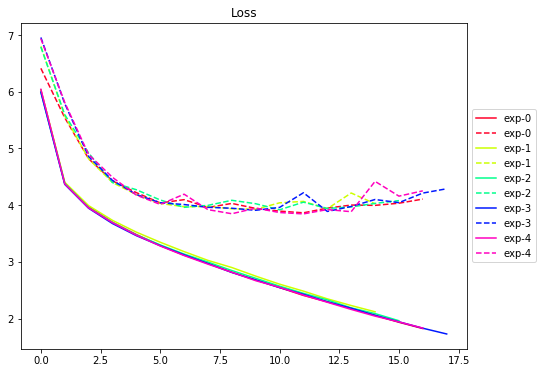

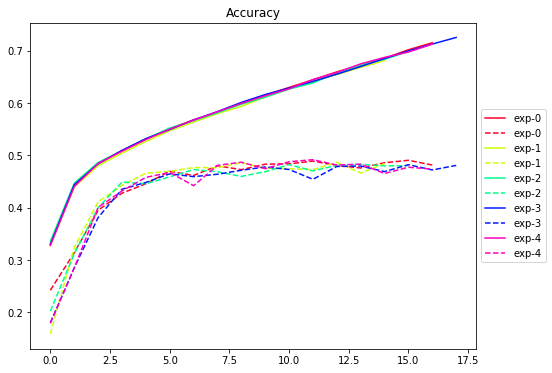

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()